In [1]:
import sys
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import math
import torch.nn.functional as F
import pytorch_lightning as pl
import multiprocessing
import warnings
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModel, AdamW, get_cosine_schedule_with_warmup
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Data:
# https://github.com/conversationai/unhealthy-conversations/tree/main/corpus

# From:
# https://www.youtube.com/watch?v=vNKIg8rXK6w

# venv:
# .\venv\Scripts\activate

torch.cuda.empty_cache()

train_data = pd.read_csv("train.csv")
train_path = "train.csv"

val_data = pd.read_csv("val.csv")
val_path = "val.csv"

train_data['unhealthy'] = np.where(train_data['healthy'] == 1, 0, 1)
attributes = ['antagonize', 'condescending', 'dismissive', "generalisation", "generalisation_unfair", "hostile", "unhealthy"]

warnings.filterwarnings("ignore")

## Dataset

In [2]:
class UCC_Dataset(Dataset):
    """
    @param sample: Because it is a highly unbalanced dataset, using the sample size manually cuts of the majority class once the max is reached
    """
    def __init__(self, data_path, tokenizer, attributes, max_token_length: int = 128, sample = 5000):
        self.data_path = data_path
        self.tokenizer = tokenizer
        self.attributes = attributes
        self.max_token_length = max_token_length
        self.sample = sample
        self.__prepare_data()


    def __prepare_data(self):
        data = pd.read_csv(self.data_path)
        data['unhealthy'] = np.where(data['healthy'] == 1, 0, 1)

        if self.sample is not None:
            unhealthy = data.loc[data[attributes].sum(axis=1) > 0 ]
            healthy = data.loc[data[attributes].sum(axis=1) == 0 ]
            self.data = pd.concat([unhealthy, healthy.sample(self.sample, random_state=666)])

        else:
            self.data = data


    def __len__(self):
        return(len(self.data))


    def __getitem__(self, index):
        item = self.data.iloc[index]
        comment = str(item.comment)

        attributes = torch.FloatTensor(item[self.attributes])
        tokens = self.tokenizer.encode_plus (comment,
                                                add_special_tokens = True,
                                                return_tensors="pt",
                                                truncation =True,
                                                max_length = self.max_token_length,
                                                padding = "max_length",
                                                return_attention_mask=True)

        return {'input_ids': tokens.input_ids.flatten(), 'attention_mask': tokens.attention_mask.flatten(), 'labels': attributes }

In [3]:
## Usage

model_name = 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
ucc_ds = UCC_Dataset(train_path, tokenizer, attributes=attributes)
ucc_ds_val = UCC_Dataset(val_path, tokenizer, attributes=attributes, sample=None)

print(ucc_ds.__getitem__(0)['labels'].shape, ucc_ds.__getitem__(0)['input_ids'].shape, ucc_ds.__getitem__(0)['attention_mask'].shape)
print(len(ucc_ds))
print(len(ucc_ds_val))

torch.Size([7]) torch.Size([128]) torch.Size([128])
9299
4427


## Data Module

In [4]:
class UCC_Data_Module(pl.LightningDataModule):

    def __init__(self, train_path, val_path, attributes, batch_size: int = 16, max_token_len: int =128, model_name = "roberta-base"):
        super().__init__()
        self.train_path = train_path
        self.val_path = val_path
        self.attributes = attributes
        self.batch_size = batch_size
        self.max_token_len = max_token_len
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

    def setup(self, stage = None):
        if stage in (None, "fit"):
            self.train_dataset = UCC_Dataset(self.train_path, self.tokenizer, self.attributes)
            self.val_dataset = UCC_Dataset(self.val_path, self.tokenizer, self.attributes, sample = None)

        if stage == "predict":
            self.val_dataset = UCC_Dataset(self.val_path, self.tokenizer, self.attributes, sample = None)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size = self.batch_size, num_workers=0, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size = self.batch_size, num_workers=0, shuffle=False)

    def predict_dataloader(self):
        return DataLoader(self.val_dataset, batch_size = self.batch_size, num_workers=0, shuffle=False)

In [5]:
## Usage

ucc_data_module = UCC_Data_Module(train_path, val_path, attributes)
ucc_data_module.setup()
print(ucc_data_module.train_dataloader())
print(len(ucc_data_module.train_dataloader()))

582


## Model

In [6]:
class UCC_Classifier(pl.LightningModule):
  def __init__(self, config: dict):
    super().__init__()
    self.config = config
    self.pretrained_model = AutoModel.from_pretrained(config['model_name'], return_dict = True)
    self.hidden = torch.nn.Linear(self.pretrained_model.config.hidden_size, self.pretrained_model.config.hidden_size)
    self.classifier = torch.nn.Linear(self.pretrained_model.config.hidden_size, self.config['n_labels'])
    torch.nn.init.xavier_uniform_(self.classifier.weight)
    self.loss_func = nn.BCEWithLogitsLoss(reduction='mean')
    self.dropout = nn.Dropout()

  def forward(self, input_ids, attention_mask, labels=None):
    # roberta layer
    output = self.pretrained_model(input_ids=input_ids, attention_mask=attention_mask)
    pooled_output = torch.mean(output.last_hidden_state, 1)
    # final logits
    pooled_output = self.dropout(pooled_output)
    pooled_output = self.hidden(pooled_output)
    pooled_output = F.relu(pooled_output)
    pooled_output = self.dropout(pooled_output)
    logits = self.classifier(pooled_output)
    # calculate loss
    loss = 0
    if labels is not None:
      loss = self.loss_func(logits.view(-1, self.config['n_labels']), labels.view(-1, self.config['n_labels']))
    return loss, logits

  def training_step(self, batch, batch_index):
    loss, outputs = self(**batch)
    self.log("train loss ", loss, prog_bar = True, logger=True)
    return {"loss":loss, "predictions":outputs, "labels": batch["labels"]}

  def validation_step(self, batch, batch_index):
    loss, outputs = self(**batch)
    self.log("validation loss ", loss, prog_bar = True, logger=True)
    return {"val_loss": loss, "predictions":outputs, "labels": batch["labels"]}

  def predict_step(self, batch, batch_index):
    loss, outputs = self(**batch)
    return outputs

  def configure_optimizers(self):
    optimizer = AdamW(self.parameters(), lr=self.config['lr'], weight_decay=self.config['w_decay'])
    total_steps = self.config['train_size']/self.config['bs']
    warmup_steps = math.floor(total_steps * self.config['warmup'])
    warmup_steps = math.floor(total_steps * self.config['warmup'])
    scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
    return [optimizer],[scheduler]

  # def validation_epoch_end(self, outputs):
  #   losses = []
  #   for output in outputs:
  #     loss = output['val_loss'].detach().cpu()
  #     losses.append(loss)
  #   avg_loss = torch.mean(torch.stack(losses))
  #   self.log("avg_val_loss", avg_loss)

# Debugging: Check if tensors require gradients
# def check_requires_grad(model):
#     for name, param in model.named_parameters():
#         if not param.requires_grad:
#             print(f"Parameter {name} does not require gradients!")

In [8]:
## Usage
config = {
    'model_name': "distilroberta-base",
    "n_labels": len(attributes),
    "bs": 16,
    "lr": 1.5e-6,
    "warmup": 0.2,
    "train_size": len(ucc_data_module.train_dataloader()),
    "w_decay": 0.001,
    "n_epochs":1
    }

model = UCC_Classifier(config)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
idx=0
input_ids = ucc_ds.__getitem__(idx)['input_ids']
attention_mask = ucc_ds.__getitem__(idx)['attention_mask']
labels = ucc_ds.__getitem__(idx)['labels']
model.cpu()
loss, output = model(input_ids.unsqueeze(dim=0), attention_mask.unsqueeze(dim=0), labels.unsqueeze(dim=0))
print(labels.shape, output.shape, output)

torch.Size([7]) torch.Size([1, 7]) tensor([[-1.8059, -0.0638,  0.2545, -0.3542, -0.4682, -0.1329, -0.1685]],
       grad_fn=<AddmmBackward0>)


In [11]:
# torch.cuda.get_device_name(0)

## Training

In [12]:
# datamodule
ucc_data_module = UCC_Data_Module(train_path, val_path, attributes=attributes, batch_size=config['bs'])
ucc_data_module.setup()

# model
model = UCC_Classifier(config)

# trainer and fit
trainer = pl.Trainer(max_epochs=config['n_epochs'], num_sanity_val_steps=10)
trainer.fit(model, ucc_data_module)


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type              | Params
-------------------------------------------------------
0 | pretrained_model | RobertaModel      | 82.1 M
1 | hidden   

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

## Make Predictions

In [55]:
# method to convert list of comments into predictions for each comment
def classify_raw_comments(model, dm):
  predictions = trainer.predict(model, datamodule=dm)
  flattened_predictions = np.stack([torch.sigmoid(torch.Tensor(p)) for batch in predictions for p in batch])
  return flattened_predictions

In [ ]:
predictions = classify_raw_comments(model, ucc_data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [58]:
val_data = pd.read_csv(val_path)
val_data['unhealthy'] = np.where(val_data['healthy'] == 1, 0, 1)
true_labels = np.array(val_data[attributes])

Text(0.5, 1.0, 'RoBERTa Trained on UCC Datatset - AUC ROC')

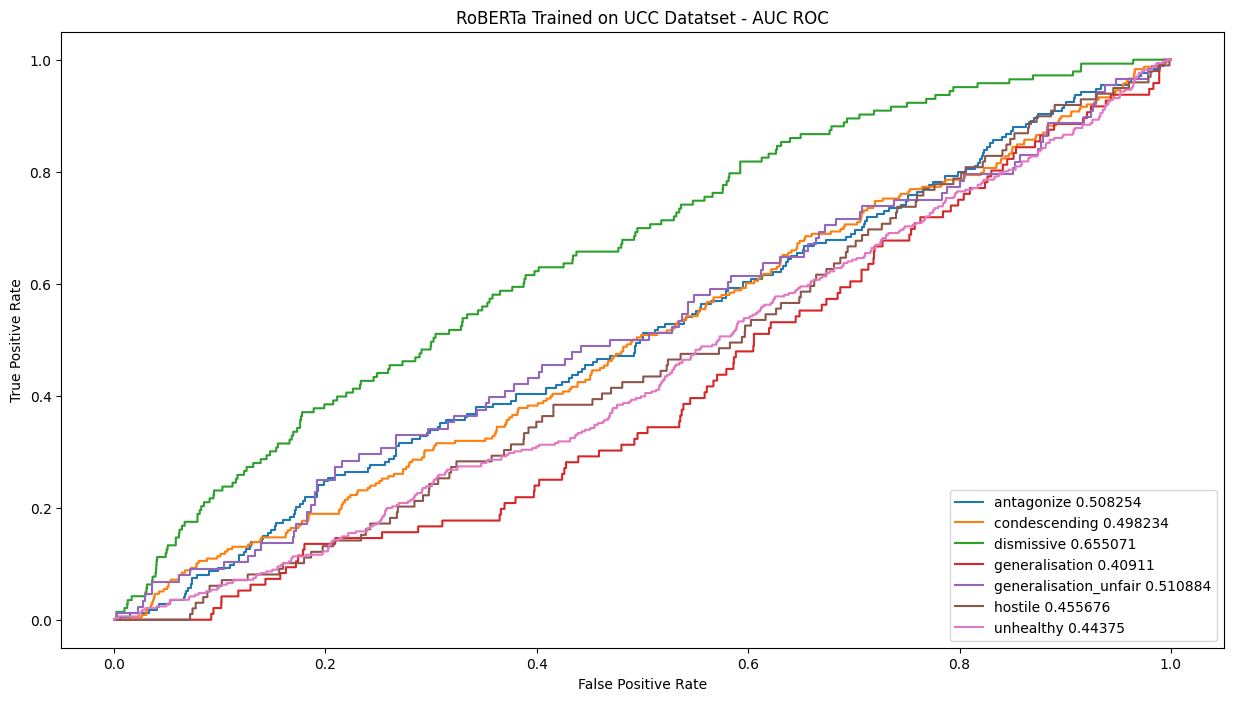

In [59]:
from sklearn import metrics
plt.figure(figsize=(15, 8))
for i, attribute in enumerate(attributes):
  fpr, tpr, _ = metrics.roc_curve(
      true_labels[:,i].astype(int), predictions[:, i])
  auc = metrics.roc_auc_score(
      true_labels[:,i].astype(int), predictions[:, i])
  plt.plot(fpr, tpr, label='%s %g' % (attribute, auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('RoBERTa Trained on UCC Datatset - AUC ROC')